In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 4050 Laptop GPU


In [2]:
import easyocr
reader = easyocr.Reader(['en'], gpu=True)

In [3]:
def extract_text(image_path):
    result = reader.readtext(image_path, detail=0)
    return " ".join(result)

text = extract_text("sample.jpg")
print("Extracted Text:\n")
print(text)

Extracted Text:

~The Court says nothing today about whether; and if so how; the Government should go about returning the billions of dollars that it has collected from importers. But that process is likely to be a mess; as was acknowledged at oral argument; he wrote_ The Treasury had collected more than USD 133 billion from the import taxes the president has imposed under the emergency powers law as of December; federal data shows. The impact over the next decade was estimated at some USD 3 trillion, news agency APreported: Implications However; the decision made on tariffs doesn't stop US President Trump from imposing duties under other laws_ While those have more limitations on the speed and severity of Trump s actions; top administration officials have said they expect to keep the tariff framework in place under other authorities. The Constitution gives Congress the power to tariffs_ But the Trump administration argued that a 1977 law allowing the president to regulate importation 

In [4]:
from transformers import pipeline

summarizer = pipeline(
    "summarization",
    model="t5-small",
    device=0
)

C:\Users\preri\anaconda3\envs\ocr_env\lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
C:\Users\preri\anaconda3\envs\ocr_env\lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
C:\Users\preri\anaconda3\envs\ocr_env\lib\site-packages\huggingface_hub\file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
sample_text = """
You could tell that Christopher Robin had something important to say from the way he clasped his knees tightly and wriggled his toes.
Everybody gathered round and looked at him expectantly.
“I’ve heard that her Majesty ...” Christopher Robin began. “Oh,” squeaked Piglet in a state of great excitement.
“Her Royal Highness ...” he went on. “Quite so, quite so,” agreed Rabbit.
“The Queen of England ...” he said quickly before anyone else could interrupt him. “Oh, The Queen,” said Pooh Bear, much relieved.
“The other people you mentioned sounded much too tall and fearsome, but The Queen is quite different.” 
Pooh had once sent a letter and was told to stick on a small picture of The Queen.
It stuck more to his nose than to the letter, 
but it told the postman that it was Most Urgent and that The Queen Says It Must Be Sent and so he was sure it had been.
“As I was saying,” said Christopher Robin, passing Pooh a honey sandwich so that he might continue speaking, 
“Her Majesty The Queen is celebrating an important birthday, her ninetieth birthday. 
And we should too. Celebrate it, that is, by giving her a present.”
"""

summary = summarizer(sample_text, max_length=80, min_length=20, do_sample=False)
print(summary[0]['summary_text'])

Pooh Bear had once sent a letter and was told to stick on a small picture of The Queen . it said the queen Says It Must Be Sent and so he was sure it had been . "her Majesty The queen is celebrating an important birthday, her ninetieth birthday," he said.


In [6]:
def ocr_summarize(image_path):
    text = extract_text(image_path)

    print("\n-----Expected Text-----")
    print(text)

    summary = summarizer(
        text,
        max_length=120,
        min_length=40,
        do_sample=False
    )

    print("\n-----Generated Summary-----")
    print(summary[0]["summary_text"])

ocr_summarize("sample.jpg")


-----Expected Text-----
~The Court says nothing today about whether; and if so how; the Government should go about returning the billions of dollars that it has collected from importers. But that process is likely to be a mess; as was acknowledged at oral argument; he wrote_ The Treasury had collected more than USD 133 billion from the import taxes the president has imposed under the emergency powers law as of December; federal data shows. The impact over the next decade was estimated at some USD 3 trillion, news agency APreported: Implications However; the decision made on tariffs doesn't stop US President Trump from imposing duties under other laws_ While those have more limitations on the speed and severity of Trump s actions; top administration officials have said they expect to keep the tariff framework in place under other authorities. The Constitution gives Congress the power to tariffs_ But the Trump administration argued that a 1977 law allowing the president to regulate impo

In [7]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", "3.0.0")

train_dataset = dataset["train"].select(range(20000))
val_dataset = dataset["validation"].select(range(13000))

In [8]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)
model = model.cuda()

C:\Users\preri\anaconda3\envs\ocr_env\lib\site-packages\huggingface_hub\file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
def preprocess_function(examples):
    inputs = ["summarize: " + doc for doc in examples["article"]]

    model_inputs = tokenizer(
        inputs,
        max_length=512,
        truncation=True,
        padding="max_length"
    )
    labels = tokenizer(
        examples["highlights"],
        max_length=128,
        truncation=True,
        padding="max_length"
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [10]:
train_tokenized = train_dataset.map(
    preprocess_function, batched=True
)
val_tokenized = val_dataset.map(
    preprocess_function, batched=True
)
train_tokenized.set_format("torch")
val_tokenized.set_format("torch")

In [11]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./t5_finetuned",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    fp16=True,
    logging_steps=200,
    save_strategy="epoch"
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized
)

C:\Users\preri\anaconda3\envs\ocr_env\lib\site-packages\accelerate\accelerator.py:439: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [12]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.067700,1.325266
2,1.024100,1.321423
3,1.036700,1.317451


TrainOutput(global_step=7500, training_loss=1.0930322631835938, metrics={'train_runtime': 1825.3961, 'train_samples_per_second': 32.87, 'train_steps_per_second': 4.109, 'total_flos': 8120508088320000.0, 'train_loss': 1.0930322631835938, 'epoch': 3.0})

In [13]:
trainer.save_model("./t5_finetuned_model")
tokenizer.save_pretrained("./t5_finetuned_model")

('./t5_finetuned_model\\tokenizer_config.json',
 './t5_finetuned_model\\special_tokens_map.json',
 './t5_finetuned_model\\spiece.model',
 './t5_finetuned_model\\added_tokens.json')

In [14]:
from transformers import pipeline

summarizer = pipeline(
    "summarization",
    model="./t5_finetuned_model",
    tokenizer="./t5_finetuned_model",
    device=0
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
import evaluate

rouge = evaluate.load("rouge")

In [16]:
def generate_summary(text):
    summary = summarizer(
        text,
        max_length=120,
        min_length=40,
        do_sample=False
    )
    return summary[0]["summary_text"]

predictions = []
references = []

for i in range(100):
    article = val_dataset[i]["article"]
    reference = val_dataset[i]["highlights"]

    pred = generate_summary(article)

    predictions.append(pred)
    references.append(reference)

results = rouge.compute(predictions=predictions, references=references)
print(results)

Token indices sequence length is longer than the specified maximum sequence length for this model (1038 > 512). Running this sequence through the model will result in indexing errors
C:\Users\preri\anaconda3\envs\ocr_env\lib\site-packages\transformers\pipelines\base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'rouge1': np.float64(0.32627466819664935), 'rouge2': np.float64(0.13700185383562258), 'rougeL': np.float64(0.23467442255677395), 'rougeLsum': np.float64(0.2738816088560163)}


In [17]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", "3.0.0")

train_small = dataset["train"].select(range(8000))
val_small = dataset["validation"].select(range(500))

In [20]:
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]','',text)
    return text

train_articles = [clean_text(x) for x in train_small["article"]]
train_summaries = ["<start> " + clean_text(x) + " <end>" for x in train_small["highlights"]]

val_articles = [clean_text(x) for x in val_small["article"]]
val_summaries = ["<start> " + clean_text(x) + " <end>" for x in val_small["highlights"]]

In [23]:
max_vocab = 8000
max_text_len = 100
max_summary_len = 25

tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(train_articles + train_summaries)

def encode_texts(texts, maxlen):
    seq = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seq, maxlen=maxlen, padding="post")

encoder_input = encode_texts(train_articles, max_text_len)
decoder_input = encode_texts(train_summaries, max_summary_len)
vocab_size = min(max_vocab, len(tokenizer.word_index)+1)

In [24]:
import numpy as np
decoder_target = np.zeros_like(decoder_input)
decoder_target[:,:-1] = decoder_input[:,1:]
decoder_target = np.expand_dims(decoder_target,-1)

In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

embedding_dim = 128
lstm_units = 256

# Encoder
encoder_inputs = Input(shape=(max_text_len,))
encoder_embedding = Embedding(vocab_size, embedding_dim)
enc_emb = encoder_embedding(encoder_inputs)

encoder_lstm = LSTM(lstm_units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_summary_len,))
decoder_embedding = Embedding(vocab_size, embedding_dim)
dec_emb = decoder_embedding(decoder_inputs)

decoder_lstm = LSTM(
    lstm_units,
    return_sequences=True,
    return_state=True
)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

decoder_dense = Dense(vocab_size, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

lstm_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Model
lstm_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

lstm_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy"
)

lstm_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)   │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_18 (InputLayer)   │ (None, 25)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_5 (Embedding)       │ (None, 100, 128)          │       1,024,000 │ input_layer_17[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_6 (Embedding)       │ (None, 25, 128)           │       1,024,000 │ input_layer_18[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_4 (LSTM)                 │ [(None, 256), (None,      │         394,240 │ embedding_5[0][0]          │
│                               │ 256), (None, 256)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_5 (LSTM)                 │ [(None, 25, 256), (None,  │         394,240 │ embedding_6[0][0],         │
│                               │ 256), (None, 256)]        │                 │ lstm_4[0][1], lstm_4[0][2] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 25, 8000)          │       2,056,000 │ lstm_5[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 4,892,480 (18.66 MB)

 Trainable params: 4,892,480 (18.66 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
history = lstm_model.fit(
    [encoder_input, decoder_input],
    decoder_target,
    epochs=6,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/6
225/225 ━━━━━━━━━━━━━━━━━━━━ 75s 320ms/step - loss: 0.5501 - val_loss: 0.0695
Epoch 2/6
225/225 ━━━━━━━━━━━━━━━━━━━━ 81s 315ms/step - loss: 0.0790 - val_loss: 0.0671
Epoch 3/6
225/225 ━━━━━━━━━━━━━━━━━━━━ 81s 312ms/step - loss: 0.0762 - val_loss: 0.0664
Epoch 4/6
225/225 ━━━━━━━━━━━━━━━━━━━━ 71s 315ms/step - loss: 0.0750 - val_loss: 0.0662
Epoch 5/6
225/225 ━━━━━━━━━━━━━━━━━━━━ 83s 319ms/step - loss: 0.0743 - val_loss: 0.0661
Epoch 6/6
225/225 ━━━━━━━━━━━━━━━━━━━━ 81s 317ms/step - loss: 0.0737 - val_loss: 0.0661


In [39]:
encoder_model = Model(encoder_inputs,encoder_states)

In [40]:
decoder_state_input_h = Input(shape=(lstm_units,))
decoder_state_input_c = Input(shape=(lstm_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_inf = Input(shape=(1,))

dec_emb2 = decoder_embedding(decoder_inputs_inf)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    dec_emb2,
    initial_state=decoder_states_inputs
)

decoder_states2 = [state_h2, state_c2]

decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs_inf] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)

In [48]:
reverse_word_index = tokenizer.index_word
word_index = tokenizer.word_index

def preprocess_input(text):
    text = clean_text(text)
    seq = tokenizer.texts_to_sequences([text])
    return pad_sequences(seq, maxlen=max_text_len,padding="post")

def greedy_decode(input_seq):
    states = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0,0] = word_index.get("start",1)
    decoded = ""
    for _ in range(max_summary_len):
        output_token = decoder_model.predict([target_seq]+states)
        sampled_index = np.argmax(output_token[0][0,-1,:])
        sampled_word = reverse_word_index.get(sampled_index,"")
        if sampled_word == "end":
            break
        decoded += " " + sampled_word
        target_seq[0,0] = sampled_index
    return decoded.strip()

In [51]:
lstm_predictions = []
lstm_references = []
for i in range(50):
    article = val_small[i]["article"]
    reference = val_small[i]["highlights"]
    pred = greedy_decode(preprocess_input(article))
    lstm_predictions.append(pred)
    lstm_references.append(reference)
lstm_results = rouge.compute(
    predictions=lstm_predictions,
    references=lstm_references
)
print(lstm_results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━

In [58]:
import pandas as pd

comparison = pd.DataFrame({
    "Model": ["LSTM-CNN", "Fine-Tuned T5"],
    "ROUGE-1": [float(lstm_results["rouge1"]), results["rouge1"]],
    "ROUGE-2": [float(lstm_results["rouge2"]), results["rouge2"]],
    "ROUGE-L": [float(lstm_results["rougeL"]), results["rougeL"]]
})
comparison

,Model,ROUGE-1,ROUGE-2,ROUGE-L
0,LSTM-CNN,0.000000,0.000000,0.000000
1,Fine-Tuned T5,0.326275,0.137002,0.234674


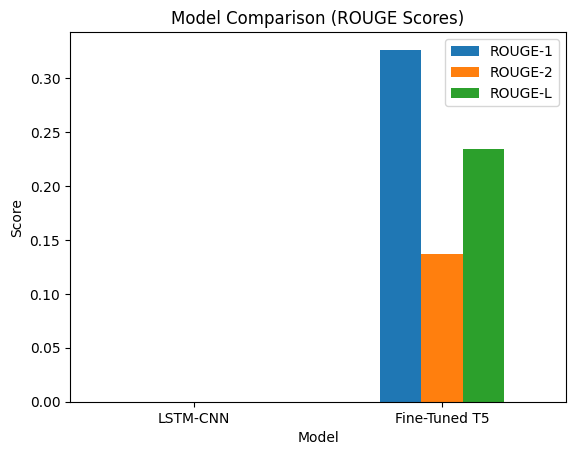

In [59]:
import matplotlib.pyplot as plt

comparison.set_index("Model").plot(kind="bar")
plt.title("Model Comparison (ROUGE Scores)")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()

In [60]:
def full_pipeline(image_path):
    text = extract_text(image_path)

    summary = summarizer(
        text,
        max_length=120,
        min_length=40,
        do_sample=False
    )[0]["summary_text"]

    print("\n-----Extracted Text------\n")
    print(text[:500],"..........")
    print("\n-----Final Summary-----\n")
    print(summary)

In [61]:
full_pipeline("sample.jpg")

C:\Users\preri\anaconda3\envs\ocr_env\lib\site-packages\transformers\pipelines\base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(



-----Extracted Text------

~The Court says nothing today about whether; and if so how; the Government should go about returning the billions of dollars that it has collected from importers. But that process is likely to be a mess; as was acknowledged at oral argument; he wrote_ The Treasury had collected more than USD 133 billion from the import taxes the president has imposed under the emergency powers law as of December; federal data shows. The impact over the next decade was estimated at some USD 3 trillion, news agenc ..........

-----Final Summary-----

The impact over the next decade was estimated at some USD 3 trillion . The decision made on tariffs doesn't stop US President Trump from imposing duties under other laws . Trump administration argued that a 1977 law allowing the president to regulate importation emergencies also allows him to set tariffs .
